In [1]:
import numpy as np
from ase import Atoms
import ase.visualize
from ase.units import Bohr

from pyscf import gto, scf, mp, cc, dft
import glob
from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/hitp')

import utils_qm as uqm
from parse_density_files import CUBE
import alchemy_tools2 as at
import explore_qml_data as eqd
import cpmd_io
import rdkit.Chem

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
import ase.io

In [3]:
def get_data(data):
    e_npbc = []
    for d in data:
        e_npbc.append(d['e_nbpc'])
    e_npbc = np.array(e_npbc)
    
    e_scaled = []
    for d in data:
        e_scaled.append(d['e_scaled'])
    e_scaled = np.array(e_scaled)

    e_el = []
    for d in data:
        e_el.append(d['e_el'])
    e_el = np.array(e_el)

    e_tot = []
    for d in data:
        e_tot.append(d['e_tot'])
    e_tot = np.array(e_tot)

    alchpots = []
    for d, e in zip(data, e_el):
        alchpots.append(e/d['nuclei'][:,0])
    alchpots = np.array(alchpots)
    
    return(alchpots, e_el, e_npbc, e_scaled, e_tot)

def sort_paths(paths, str_pos1, str_pos2, split1, split2):
    paths_tuple = []
    for p in paths:
        sorting_string = p.split(split1)[str_pos1]
        value = float(sorting_string.split(split2)[str_pos2])
        paths_tuple.append((value, p))
    paths_tuple.sort()
    paths_sorted = []
    for p in paths_tuple:
        paths_sorted.append(p[1])
    return(paths_sorted)

import pymatgen.analysis.ewald
def ewald(a, mol):
    
    #geometries['ang_1.42429'].get_positions(),
    
    #a = 18.886527828347333
    s = pymatgen.core.structure.Structure(
        [[a, 0, 0], [0, a, 0], [0, 0, a]],
        species=mol.get_chemical_symbols(),
        coords=mol.get_positions(),
        charge=0,
        coords_are_cartesian=True,
        site_properties={"charge": mol.get_atomic_numbers()}
    )
    e = pymatgen.analysis.ewald.EwaldSummation(s)
    return e.total_energy*0.0367493  # Ha

def ewald_site(a, mol):
    
    #geometries['ang_1.42429'].get_positions(),
    
    #a = 18.886527828347333
    s = pymatgen.core.structure.Structure(
        [[a, 0, 0], [0, a, 0], [0, 0, a]],
        species=mol.get_chemical_symbols(),
        coords=mol.get_positions(),
        charge=0,
        coords_are_cartesian=True,
        site_properties={"charge": mol.get_atomic_numbers()}
    )
    e = pymatgen.analysis.ewald.EwaldSummation(s)
    
    nuc_rep_site = []
    for i in range(len(mol.get_atomic_numbers())):
        nuc_rep_site.append(e.get_site_energy(i)*0.0367493)
    return(np.array(nuc_rep_site))

# Sum of atomic energies vs energy of whole molecule

In [6]:
zeff_bool = True
geom_type = 'bond'

In [7]:
if geom_type == 'bond':
# cpmd_bond = np.loadtxt('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/cpmd_en.txt')
    cpmd_bond = np.loadtxt('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/cpmd_en.txt')

# cpmd_angle = np.loadtxt('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/cpmd_en.txt')
# cpmd_dihe = np.loadtxt('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/dihedrals/butanol/cpmd_en.txt')

In [8]:
if geom_type == 'bond':
    paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_*/results.dict')
# paths_glob = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/ang*/results.dict')

paths = sort_paths(paths_glob, -2, -1, '/','_')

data = []
for p in paths:
    data.append(uqm.load_obj(p))
    
geometries = dict()
rcoord = []
zeff = np.array([4., 4, 4, 4, 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
for d in data:
    nuc_charges = d['nuclei'][:,0]
    pos = d['nuclei'][:,1:]*Bohr
    pos = eqd.shift2center(pos, [0,0,0])
    if zeff_bool:
        molecule = Atoms(numbers=zeff, positions=pos)
    else:
        molecule = Atoms(numbers=nuc_charges, positions=pos)
#     ang = np.round(molecule.get_angle(1, 2,4))
    if geom_type == 'bond':
        ang = np.round(molecule.get_distance(2,4), 5)
    rcoord.append(ang)
    geometries[f'd_{ang}'] = molecule

alchpots, e_el, e_npbc, e_scaled, e_tot = get_data(data)

In [9]:
for k in geometries.keys():
    d = np.round(geometries[k].get_distance(2,4), 2)
    ase.io.write(f'/data/sahre/projects/atomic-energies/data/UFF_energies/butanol_bond/d_{d}.xyz', geometries[k])
#     print(d)

In [10]:
geometries

{'d_0.92429': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.04929': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.17429': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.29929': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.42429': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.67429': Atoms(symbols='Be4CH10', pbc=False),
 'd_1.92429': Atoms(symbols='Be4CH10', pbc=False),
 'd_2.17429': Atoms(symbols='Be4CH10', pbc=False),
 'd_2.42429': Atoms(symbols='Be4CH10', pbc=False)}

In [11]:
e_el_zeff = (alchpots*zeff).sum(axis=1)
e_el_zeff

array([-194.56434576, -192.13806452, -189.96885136, -188.03949728,
       -186.32466511, -183.365677  , -180.89051402, -178.80817799,
       -177.01692757])

In [12]:
# cpmd energy contributions
# paths = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_*/ve_32/run.log')
paths = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol_plane/ang*/ve_32/run.log')


paths = sort_paths(paths, -3, -1, "/", '_')

energy_contributions = {'TOTAL ENERGY =':[], 'KINETIC ENERGY =':[], 'ELECTROSTATIC ENERGY =':[], '(E+I)-(E+I) HARTREE ENERGY =':[], 
                   '(PSEUDO CHARGE I-I) ENERGY =':[], '(E-E) HARTREE ENERGY =':[], 'ESELF =':[], 'ESR =':[], 'LOCAL PSEUDOPOTENTIAL ENERGY =':[],
                   'N-L PSEUDOPOTENTIAL ENERGY =':[], 'EXCHANGE-CORRELATION ENERGY =':[], 'GRADIENT CORRECTION ENERGY =':[]}

for p in paths:

    with open(p, 'r') as f:
        logfile = f.readlines()

    for k in energy_contributions.keys():
        energy_contributions[k].append(cpmd_io.get_energy_contribution(logfile, k))
    
for k in energy_contributions.keys():
    energy_contributions[k] = np.array(energy_contributions[k])
    
nuc_rep_cpmd = energy_contributions['(PSEUDO CHARGE I-I) ENERGY ='] + energy_contributions['ESR ='] - energy_contributions['ESELF ='] # should be ESR added or subtracted?

# if I add up contributions as in log-file I get total energy if ESR is added not subtracted
total_energy = energy_contributions['KINETIC ENERGY =']+energy_contributions['(E+I)-(E+I) HARTREE ENERGY =']+energy_contributions['ESR =']-energy_contributions['ESELF =']+energy_contributions['LOCAL PSEUDOPOTENTIAL ENERGY =']+energy_contributions['N-L PSEUDOPOTENTIAL ENERGY =']+energy_contributions['EXCHANGE-CORRELATION ENERGY =']


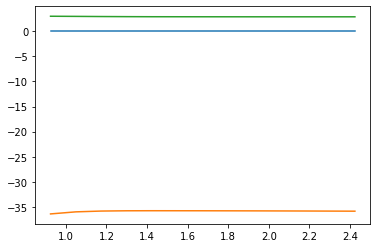

In [13]:
for k in ['(E+I)-(E+I) HARTREE ENERGY =', 'LOCAL PSEUDOPOTENTIAL ENERGY =', 'N-L PSEUDOPOTENTIAL ENERGY =']:
    plt.plot(rcoord, energy_contributions[k])

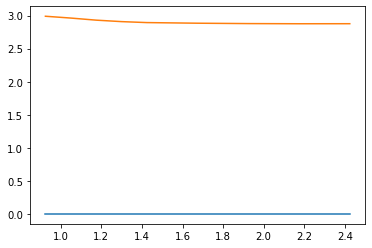

In [14]:
for k in ['(E+I)-(E+I) HARTREE ENERGY =', 'N-L PSEUDOPOTENTIAL ENERGY =']:
    plt.plot(rcoord, energy_contributions[k])

In [15]:
energy_contributions

{'TOTAL ENERGY =': array([-44.41623595, -44.59671371, -44.68273665, -44.71951074,
        -44.72975981, -44.72229476, -44.69995708, -44.66331302,
        -44.61232041]),
 'KINETIC ENERGY =': array([36.43092357, 36.03113282, 35.8401953 , 35.76710944, 35.75367752,
        35.7721212 , 35.81137136, 35.86788857, 35.9398908 ]),
 'ELECTROSTATIC ENERGY =': array([-33.21147971, -33.43226418, -33.49163165, -33.50468386,
        -33.50383403, -33.49768278, -33.48811001, -33.47480022,
        -33.45639294]),
 '(E+I)-(E+I) HARTREE ENERGY =': array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '(PSEUDO CHARGE I-I) ENERGY =': array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '(E-E) HARTREE ENERGY =': array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'ESELF =': array([36.56970904, 36.56970904, 36.56970904, 36.56970904, 36.56970904,
        36.56970904, 36.56970904, 36.56970904, 36.56970904]),
 'ESR =': array([2.65801764, 2.44550308, 2.3908291 , 2.37819039, 2.37618869,
        2.37757822, 2.3815639 , 2.38962196, 2.40492491]),
 'LOCAL PSEUDOP

In [16]:
# ewald energies

In [20]:
box_length = 18.886527828347333
ewald_energies = []
ewald_all = []
for k in geometries.keys():
#     ewald_energies.append(ewald(box_length, geometries[k]))
    ewald_energies.append(ewald_site(box_length, geometries[k]))
    ewald_all.append(ewald(box_length, geometries[k]))
ewald_energies = np.array(ewald_energies)

# fig, ax = plt.subplots(1,2)
# ax[0].plot(rcoord, ewald_energies, label = 'pymatgen')
# ax[0].plot(rcoord, nuc_rep_cpmd, label = 'CPMD')
# ax[0].set_xlabel("d (Ang)")
# ax[0].set_ylabel('E_NN (Ha)')
# ax[1].plot(rcoord, nuc_rep_cpmd-ewald_energies, label = 'CPMD-pymatgen')
# ax[1].set_xlabel("d (Ang)")
# ax[1].set_ylabel(r'$\Delta$E_NN (Ha)')
# ax[0].legend()
# ax[1].legend()
# fig.tight_layout()

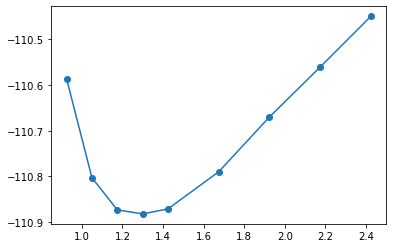

In [18]:
plt.plot(rcoord, (alchpots*zeff+ewald_energies).sum(axis=1), '-o')

In [21]:
ewald_all

[83.97832149776869,
 81.33533073027911,
 79.0955164629232,
 77.15726731970335,
 75.4534393344074,
 72.57573466100816,
 70.22055160821375,
 68.2475893901379,
 66.56748377432845]

In [106]:
plt.plot(rcoord, (alchpots*zeff+ewald_energies), '-o')

[0.92429,
 1.04929,
 1.17429,
 1.29929,
 1.42429,
 1.67429,
 1.92429,
 2.17429,
 2.42429]

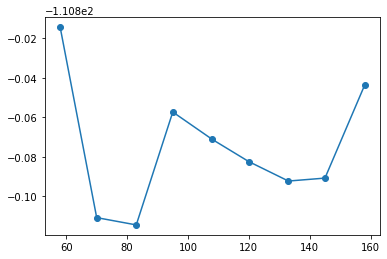

In [23]:
plt.plot(rcoord,ewald_energies+e_el_zeff, '-o')

In [22]:
rcoord

[58.0, 70.0, 83.0, 95.0, 108.0, 120.0, 133.0, 145.0, 158.0]

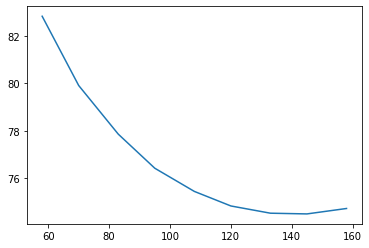

In [55]:
plt.plot(rcoord, ewald_energies)

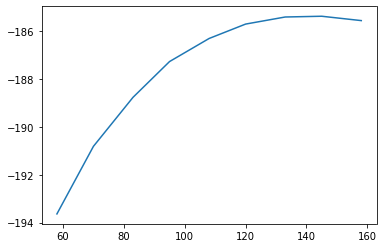

In [52]:
plt.plot(rcoord,e_el_zeff)

In [56]:
ewald_energies+e_el_zeff

array([-110.81441289, -110.91080203, -110.91449435, -110.85732949,
       -110.87122578, -110.88245475, -110.89228294, -110.89079012,
       -110.84387015])

No handles with labels found to put in legend.


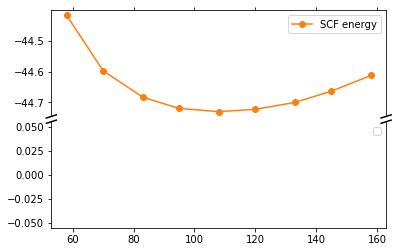

In [49]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# ax2.plot(rcoord, e_el_zeff+nuc_rep_cpmd, '-o', label="alchemy energy + CPMD nuc_rep") # +2*energy_contributions['ESELF =']
ax.plot(rcoord, energy_contributions['TOTAL ENERGY ='], '-o', color = 'tab:orange', label = 'SCF energy')
# ax.plot(rcoord, total_energy, '--')

# # hide the spines between ax and ax2
# ax_cpmd.spines.bottom.set_visible(False)
# ax_alch.spines.top.set_visible(False)
# ax_cpmd.xaxis.tick_top()
# ax_cpmd.tick_params(labeltop=False)  # don't put tick labels at the top
# ax_alch.xaxis.tick_bottom()

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend()
ax2.legend()

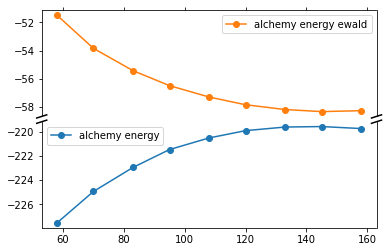

In [51]:
# plt.plot(rcoord, e_el_zeff + ewald_energies, '-o',label="alchemy energy ewald")
# plt.plot(rcoord, e_el_zeff+nuc_rep_cpmd, '-o', label="alchemy energy") # +2*energy_contributions['ESELF =']


fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

ax.plot(rcoord, e_el_zeff + ewald_energies, '-o',label="alchemy energy ewald", color='tab:orange') # +2*energy_contributions['ESELF =']
ax2.plot(rcoord, e_el_zeff+nuc_rep_cpmd, '-o', label="alchemy energy")

# # hide the spines between ax and ax2
# ax_cpmd.spines.bottom.set_visible(False)
# ax_alch.spines.top.set_visible(False)
# ax_cpmd.xaxis.tick_top()
# ax_cpmd.tick_params(labeltop=False)  # don't put tick labels at the top
# ax_alch.xaxis.tick_bottom()

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend()
ax2.legend()

SCF calculates ion-electron interaction via pseudopotential, we describe interaction with 1/r term
valence electron density from PP calculation different from ved from all electron calculation -> PP should be used in principle?

non local pseudopotential not scaled

numerical errors in integration wrt lambda, r

DFT is bad in describing anions bond breaking 


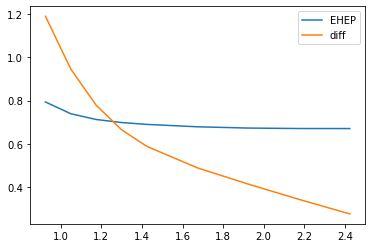

In [44]:
# energy_contributions['(E+I)-(E+I) HARTREE ENERGY ='] contains hartree energy of electrons and of nuclei repulsion
# Why is it so small almost the difference between II and hartree


diff_ps_ii_h = energy_contributions['(E-E) HARTREE ENERGY =']-energy_contributions['(PSEUDO CHARGE I-I) ENERGY =']

plt.plot(rcoord, energy_contributions['(E+I)-(E+I) HARTREE ENERGY ='], label='EHEP')
plt.plot(rcoord, diff_ps_ii_h, label = 'diff')
plt.legend()

# Energy as function of lambda

In [26]:
paths_lambda = glob.glob('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_0.0/ve_*/run.log')
paths_lambda = sort_paths(paths_lambda, -2, -1, "/", '_')

energy_contributions = {'TOTAL ENERGY =':[], 'KINETIC ENERGY =':[], 'ELECTROSTATIC ENERGY =':[], '(E+I)-(E+I) HARTREE ENERGY =':[], 
                   '(PSEUDO CHARGE I-I) ENERGY =':[], '(E-E) HARTREE ENERGY =':[], 'ESELF =':[], 'ESR =':[], 'LOCAL PSEUDOPOTENTIAL ENERGY =':[],
                   'N-L PSEUDOPOTENTIAL ENERGY =':[], 'EXCHANGE-CORRELATION ENERGY =':[], 'GRADIENT CORRECTION ENERGY =':[]}

for p in paths_lambda:

    with open(p, 'r') as f:
        logfile = f.readlines()

    for k in energy_contributions.keys():
        energy_contributions[k].append(cpmd_io.get_energy_contribution(logfile, k))
    
for k in energy_contributions.keys():
    energy_contributions[k] = np.array(energy_contributions[k])
    
nuc_rep_cpmd = energy_contributions['ESR =']+energy_contributions['(PSEUDO CHARGE I-I) ENERGY =']-energy_contributions['ESELF =']

lam_vals = np.array([0, 13, 19, 26, 32])/32
# electronic_interactions = energy_contributions['KINETIC ENERGY =']+energy_contributions['EXCHANGE-CORRELATION ENERGY =']+energy_contributions['GRADIENT CORRECTION ENERGY =']+energy_contributions['(E+I)-(E+I) HARTREE ENERGY =']#+energy_contributions['(E-E) HARTREE ENERGY =']
# electron_nuclei_interaction = energy_contributions['LOCAL PSEUDOPOTENTIAL ENERGY =']+energy_contributions['N-L PSEUDOPOTENTIAL ENERGY =']
# nuclei_interactions = energy_contributions['ESR ='] - energy_contributions['ESELF =']#+energy_contributions['(PSEUDO CHARGE I-I) ENERGY =']

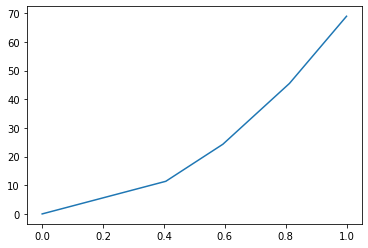

In [27]:
plt.plot(lam_vals, nuc_rep_cpmd)

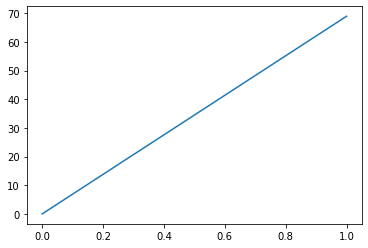

In [29]:
plt.plot(lam_vals**2, nuc_rep_cpmd)

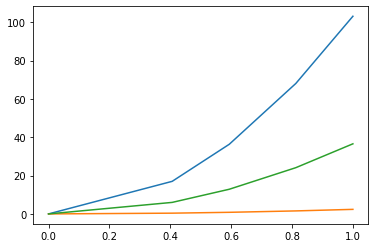

In [28]:
plt.plot(lam_vals, energy_contributions['(PSEUDO CHARGE I-I) ENERGY ='])

plt.plot(lam_vals, energy_contributions['ESR ='])
plt.plot(lam_vals, energy_contributions['ESELF ='])




# Ewald summation nuclear repulsion

In [55]:
import numpy as np
from ase import Atoms
import ase.visualize
from ase.units import Bohr
#from pyscf import gto, scf, mp, cc, dft
from pyscf.pbc import gto as gto_pbc
from pyscf import gto as gto
import glob
from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

import utils_qm as uqm
from parse_density_files import CUBE
import alchemy_tools2 as at
import explore_qml_data as eqd


In [56]:
import pymatgen
import pymatgen.analysis.ewald
def ewald(a, mol):
    
    #geometries['ang_1.42429'].get_positions(),
    
    #a = 18.886527828347333
    s = pymatgen.core.structure.Structure(
        [[a, 0, 0], [0, a, 0], [0, 0, a]],
        species=mol.get_chemical_symbols(),
        coords=mol.get_positions(),
        charge=0,
        coords_are_cartesian=True,
        site_properties={"charge": mol.get_atomic_numbers()}
    )
    e = pymatgen.analysis.ewald.EwaldSummation(s)
    return e.total_energy*0.0367493  # Ha

In [57]:
data = uqm.load_obj('/data/sahre/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_0.0/results.dict')
molecule = Atoms(numbers=data['nuclei'][:,0], positions=data['nuclei'][:,1:]*Bohr)

molecule = Atoms(numbers=np.array([4., 4., 4., 4., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), positions=data['nuclei'][:,1:]*Bohr)

In [59]:
ewald(18.886527828347333, molecule)

75.45343933440739

In [ ]:
ewald(20, molecule)

In [ ]:
nuc_rep_ewald = []
for b in [20, 50, 100, 1000, 10000]:
    nuc_rep_ewald.append(ewald(b, molecule))

In [ ]:
plt.plot([20, 50, 100, 1000, 10000], nuc_rep_ewald, '-o')
plt.xlabel('boxsize (Ang)')
plt.ylabel('Energy (Ha)')

In [ ]:
nuc_rep_ewald

In [ ]:
molecule

In [ ]:
atoms = uqm.ase2pyscf(molecule)

In [ ]:
mol = gto.Mole()
mol.atom = atoms
mol.unit = "Angstrom"
mol.build()
mol.energy_nuc()

In [ ]:
cell = gto_pbc.Cell()
cell.atom = (atoms)
# cell.basis = 'gth-dzvp'
# cell.pseudo = 'gth-pade'
mol.unit = "Angstrom"

cell.a = np.eye(3) * 20
cell.build()
cell.energy_nuc()

In [ ]:
ekin = 35.7536775
eii = 103.11776806
eeehar = 103.70550638
eself = 36.56970904
esr = 2.37618869
eloc = -35.75782162
enonloc = 2.89383194
exc = -14.11561362
egrad = -0.26644510

In [ ]:
eeehar-eii

In [ ]:
cell.atom

In [ ]:
>>> from pyscf.pbc import gto
>>> cell = gto.Cell()
>>> cell.atom = '''H  0 0 0; H 1 1 1'''
>>> cell.basis = 'gth-dzvp'
>>> cell.pseudo = 'gth-pade'
>>> cell.a = numpy.eye(3) * 2
>>> cell.build()
